In [63]:
from IPython.display import display, Markdown
import pandas as pd

total_dataset_clean = pd.read_stata("data_base_enrichie_totalement_clean.dta") 


In [64]:
markdown = """
Ici, on ameliore notre modele dans 3_reg_and_tests. on souhaite selectionner des variables d'amenités tout en évitant l'overfit. pour ce faire, on fait une regression lasso. 

On inclut ce vecteur d'amenités aux regresseurs de notre premiere regression dans 3_reg_and_test. En prédisant les depenses en logement avec des amenités (qui expliquent une demande pour le logement), on isole l'effet de la variable catégorielle territoire et on réduit la surestimation de ses coefficients.
"""
display(Markdown(markdown))





Ici, on ameliore notre modele dans 3_reg_and_tests. on souhaite selectionner des variables d'amenités tout en évitant l'overfit. pour ce faire, on fait une regression lasso. 

On inclut ce vecteur d'amenités aux regresseurs de notre premiere regression dans 3_reg_and_test. En prédisant les depenses en logement avec des amenités (qui expliquent une demande pour le logement), on isole l'effet de la variable catégorielle territoire et on réduit la surestimation de ses coefficients.


In [65]:
# nos variables dans la regression 3.reg_and_test
# et on ajoute les variables decrivant des amenites de logement
# on conduit notre regression LASSO avec nos variables dans regression 3.reg_and_test et ces amenites de logement
# il faut qu'au final, on est toutes nos variables de 3_reg_and_test (categorie territoire et var sociocategorielles)

variables = ['territory','level_educ','age', 'marital_status','gender', 'own_status','Numrooms', 'Numroomsleep', 'Sanserv1', 'Sanserv2', 'Garbdisp', 'Watserv', 'Kitchen', 'Fuelc',
             'Phone_service', 'tvservice', 'Internet_service', 'Washing', 'Refrigerator', 'Blender', 'Stove',
             'Oven', 'Microwave', 'Water_heater', 'ColorTV', 'Computer', 'AirCond', 'typeofbuilding', 'Stereo',
             'Floor', 'Wallsmaterial','Garbcollectfreq','Dummyelec',
             'Utilrank', 'Naturalgas', 'Sewage_system', 'Garbcollect', 'Aqueduct', 'Frequencewat']


1. Preprocessing

In [66]:
# ici, on cherche toutes les variables categorielles qui demandent une transformation en dummy variable 

#value_counts_dict = {} #si on veut les value counts
value_counts_dict = []

# boucle qui filtre les var categorielles (sans prendre les var qu'on ne veut pas transformer)
for col in variables:
    unique_values_count = total_dataset_clean[col].nunique()
    if unique_values_count and col not in ['Numrooms', 'Numroomsleep','age']:
        #value_counts_dict[col] = total_dataset_clean[col].value_counts()   #pour avoir le compte. on a juste besoin du nom des vars 
        value_counts_dict.append(col)
print("Variables categorielles à preprocesser:")
print(value_counts_dict)
data = total_dataset_clean[value_counts_dict]


for column in value_counts_dict: #on cree les dummies puis on concatene
    dummies = pd.get_dummies(data[column], prefix=column, dtype=float, drop_first=True)
    data = pd.concat([data, dummies], axis=1)

data = data.drop(value_counts_dict, axis=1) #base de preprocessing clean, il manque les variables 


Variables categorielles à preprocesser:
['territory', 'level_educ', 'marital_status', 'gender', 'own_status', 'Sanserv1', 'Sanserv2', 'Garbdisp', 'Watserv', 'Kitchen', 'Fuelc', 'Phone_service', 'tvservice', 'Internet_service', 'Washing', 'Refrigerator', 'Blender', 'Stove', 'Oven', 'Microwave', 'Water_heater', 'ColorTV', 'Computer', 'AirCond', 'typeofbuilding', 'Stereo', 'Floor', 'Wallsmaterial', 'Garbcollectfreq', 'Dummyelec', 'Utilrank', 'Naturalgas', 'Sewage_system', 'Garbcollect', 'Aqueduct', 'Frequencewat']


In [67]:
from sklearn.preprocessing import MinMaxScaler

# on transforme nos variables continues 
scaler = MinMaxScaler()
data_preprocess = scaler.fit_transform(total_dataset_clean[['Numrooms', 'Numroomsleep']])
data_preprocess = pd.DataFrame(data_preprocess, columns=['Numrooms', 'Numroomsleep'])

# on garde age comme tel
age = pd.DataFrame(total_dataset_clean["age"], columns = ["age"])

In [68]:
# on cree notre base pour la regression : on concatene les trois bases precedentes
X = pd.concat([data, data_preprocess], axis=1)
X = pd.concat([X, age], axis=1)
# on cree la base de la variable dependente a predire
y = total_dataset_clean['log_imputed_rent_uc']

# et fin du preprocessing, on droppe les NaN
X_y = pd.concat([X,y],axis=1)
X_y = X_y.dropna()

y = X_y['log_imputed_rent_uc']
X = X_y.drop('log_imputed_rent_uc', axis=1)


2. Premiere regression LASSO pour selectionner les variables d'amenites

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import numpy as np

# on cree nos donnees de training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# cross-validation 
lasso_model = LassoCV(alphas=np.logspace(-15, 15, 200), cv=5, max_iter=10000)

# et on fitte avec les donnees de training
lasso_model.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.099227719101236, tolerance: 0.5867612020482981
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.90151056598825, tolerance: 0.5867612020482981
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(alphas=array([1.00000000e-15, 1.41499130e-15, 2.00220037e-15, 2.83309610e-15,
       4.00880633e-15, 5.67242607e-15, 8.02643352e-15, 1.13573336e-14,
       1.60705282e-14, 2.27396575e-14, 3.21764175e-14, 4.55293507e-14,
       6.44236351e-14, 9.11588830e-14, 1.28989026e-13, 1.82518349e-13,
       2.58261876e-13, 3.65438307e-13, 5.17092024e-13, 7.31680714e-13,
       1.03532184e-12, 1.46497140e-1...
       3.40928507e+11, 4.82410870e+11, 6.82607183e+11, 9.65883224e+11,
       1.36671636e+12, 1.93389175e+12, 2.73644000e+12, 3.87203878e+12,
       5.47890118e+12, 7.75259749e+12, 1.09698580e+13, 1.55222536e+13,
       2.19638537e+13, 3.10786619e+13, 4.39760361e+13, 6.22257084e+13,
       8.80488358e+13, 1.24588336e+14, 1.76291412e+14, 2.49450814e+14,
       3.52970730e+14, 4.99450512e+14, 7.06718127e+14, 1.00000000e+15]),
        cv=5, max_iter=10000)

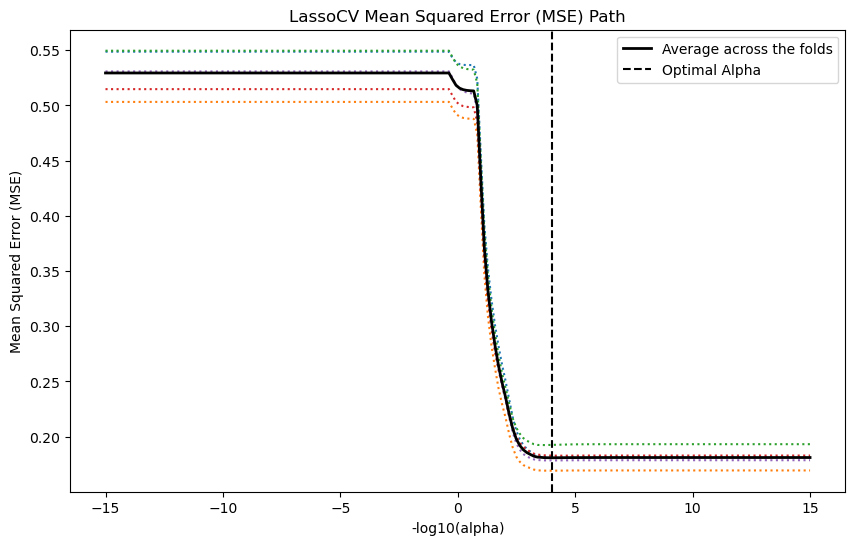

In [70]:
# on plotte notre alpha optimal 
import matplotlib.pyplot as plt

m_log_alphas = -np.log10(lasso_model.alphas_)

plt.figure(figsize=(10, 6))
plt.plot(m_log_alphas, lasso_model.mse_path_, ':')
plt.plot(m_log_alphas, lasso_model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso_model.alpha_), linestyle='--', color='k', label='Optimal Alpha')

plt.legend()
plt.xlabel('-log10(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LassoCV Mean Squared Error (MSE) Path')
plt.show() 

In [72]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.19995948917389672


In [73]:
test_score = lasso_model.score(X_test, y_test)
print(f'R-squared: {test_score}')
# R-squared (coefficient de determination) score sur la base test

R-squared: 0.6252845664464224


In [74]:
optimal_alpha = lasso_model.alpha_ #notre alpha optimal
optimal_alpha_original_scale = 10**optimal_alpha
print(f'Alpha optimal: {optimal_alpha_original_scale}')

Alpha optimal: 1.0002329653853932


In [75]:
from sklearn.linear_model import Lasso

# avec ce alpha optimal, on reconduit une reg lasso, pour enfin selectionner les variables avec ce alpha optimal (donc minimisation du squared error)
lasso_final = Lasso(alpha=optimal_alpha)

# et on fitte le modele sur les donnes d'entrainement
lasso_final.fit(X_train, y_train)

Lasso(alpha=0.0001011637979766207)

In [76]:
pd.set_option('display.max_columns', None) #on veut voir toutes les colonnes de la base
coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_final.coef_})
coefficients_df.T

to_exclude = coefficients_df[coefficients_df['Coefficient'].abs()==0]
to_exclude.T
to_exclude = [element.split('_')[0] for element in to_exclude['Variable']]
to_exclude = list(set(to_exclude))
to_exclude

['Watserv',
 'Garbdisp',
 'Floor',
 'Stereo',
 'Fuelc',
 'Frequencewat',
 'Wallsmaterial',
 'Sanserv1']

In [77]:
others = coefficients_df[coefficients_df['Coefficient'].abs()!=0]
others.T
others = [element.split('_')[0] for element in others['Variable']]
others = list(set(others))
others

['Watserv',
 'Internet',
 'gender',
 'Garbcollectfreq',
 'ColorTV',
 'Naturalgas',
 'Wallsmaterial',
 'level',
 'Kitchen',
 'Oven',
 'Blender',
 'Water',
 'Garbcollect',
 'Numroomsleep',
 'Fuelc',
 'age',
 'Washing',
 'Phone',
 'Computer',
 'Stove',
 'territory',
 'Sanserv1',
 'Dummyelec',
 'marital',
 'Garbdisp',
 'Floor',
 'Numrooms',
 'Microwave',
 'Frequencewat',
 'Refrigerator',
 'AirCond',
 'Utilrank',
 'Sewage',
 'Aqueduct',
 'tvservice',
 'Sanserv2',
 'own',
 'typeofbuilding']

In [78]:
features = list(set(others)-set(to_exclude))
features #le vecteur d'amenites qu'on retient donc
# attention aux noms de variables qui incluait "_" avant comme own_status ou level_educ

['Internet',
 'gender',
 'Garbcollectfreq',
 'ColorTV',
 'Naturalgas',
 'level',
 'Kitchen',
 'Oven',
 'Blender',
 'Water',
 'Garbcollect',
 'Numroomsleep',
 'age',
 'Washing',
 'Phone',
 'Computer',
 'Stove',
 'territory',
 'Dummyelec',
 'marital',
 'Numrooms',
 'Microwave',
 'Refrigerator',
 'AirCond',
 'Utilrank',
 'Sewage',
 'Aqueduct',
 'tvservice',
 'Sanserv2',
 'own',
 'typeofbuilding']

si le coefficient d'une dummy représentant une catégorie spécifique d'une variable catégorielle est exactement 0 dans la regularisation Lasso, on peut exclure non seulement cette dummy, mais aussi les autres dummies associees a la meme variable categorielle.

La régularisation Lasso tend à pousser certains coefficients a etre exactement 0, cela signifie que la categorie particuliere et ses dummies associees ne contribuent pas au modele selon la regularisation. En excluant les dummies associees a cette meme variable categorielle, on evite des problemes de multicollinearite et on simplifie le modele pour eviter l'overfit


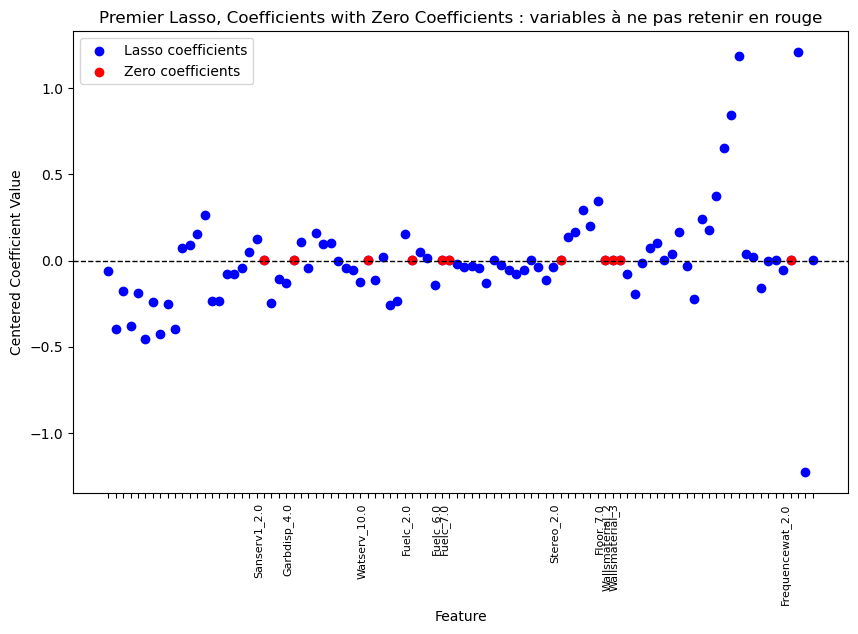

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# on centre l'axis 
centered_coefs = lasso_model.coef_ - np.mean(lasso_model.coef_)

# filtre pour colorer les coeff ==0
zero_coef_mask = np.isclose(lasso_model.coef_, 0)

# graph
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(lasso_model.coef_)), centered_coefs, color='b', label='Lasso coefficients')
plt.scatter(np.arange(len(lasso_model.coef_))[zero_coef_mask], centered_coefs[zero_coef_mask], color='red', label='Zero coefficients')

# labels
x_labels = [label if mask else "" for label, mask in zip(X.columns, zero_coef_mask)]
plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90, ha="right", fontsize=8)

plt.xlabel('Feature')
plt.ylabel('Centered Coefficient Value')
plt.title('Premier Lasso, Coefficients with Zero Coefficients : variables à ne pas retenir en rouge')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
plt.legend()
plt.show()

In [80]:

markdown = """
Fort heureusement, nos variables de territoire et sociocategorielles ont ete retenues. 
Sinon, on aurait eu surement à faire un LASSO avec contrainte, eg. minimiser le mean square error en obligeant à avoir les dummies territory et sociocategoriques dans la L1 regularisation 
Ou bien une regression ridge. mais le souci de la ridge, c'est la regularisation en L2: le terme de penalite permet aux coefficients des variables de converger vers 0, mais pas =0, et on veut absolument selectionner les variables 

Donc on fait notre selection de variables en deux temps : \n1. on fait une regression lasso qui permet de selectionner les variables tout en minimisant le MSE \n* fait au dessus\n 2. avec la liste de features obtenue, on corrige les problemes de collinéarité \n* on analyse les VIF 
            \n* puis on relance un LASSO avec les variables avec les VIF les plus bas, pour s'assurer qu'on selectionne une bonne liste de variables

"""
display(Markdown(markdown))


Fort heureusement, nos variables de territoire et sociocategorielles ont ete retenues. 
Sinon, on aurait eu surement à faire un LASSO avec contrainte, eg. minimiser le mean square error en obligeant à avoir les dummies territory et sociocategoriques dans la L1 regularisation 
Ou bien une regression ridge. mais le souci de la ridge, c'est la regularisation en L2: le terme de penalite permet aux coefficients des variables de converger vers 0, mais pas =0, et on veut absolument selectionner les variables 

Donc on fait notre selection de variables en deux temps : 
1. on fait une regression lasso qui permet de selectionner les variables tout en minimisant le MSE 
* fait au dessus
 2. avec la liste de features obtenue, on corrige les problemes de collinéarité 
* on analyse les VIF 
            
* puis on relance un LASSO avec les variables avec les VIF les plus bas, pour s'assurer qu'on selectionne une bonne liste de variables



In [ ]:
# etude de la multicollinearite entre les variables selectionnees 

In [81]:
# renomme les vars avec des underscores 

# petit dictionnaire
replacement_dict = {'Internet': 'Internet_service', 'Phone': 'Phone_service', 'Water': 'Water_heater', 'Sewage': 'Sewage_system',
'own':'own_status', 'level':'level_educ', 'marital':'marital_status'}

# on renomme
features = [replacement_dict.get(col, col) for col in features]

In [82]:
from IPython.display import display, Markdown

markdown = """
La regression retient beaucoup de variables. on va relancer un LASSO pour eviter un probleme de bad controls.

Mais avant ca, on analyse les VIF de chaque variable selectionnée par la regression, on peut supprimer des variables collineaires. 
On supprime les variables avec des VIF très élevés : on peut supprimer typeofbuilding, Dummyelec, Garbcollect qui ont des VIF tres tres eleves 
puis on recalcule les VIF et on utilise une matrice de correlation pour identifier les variables qui sont multicollineaires a d'autres. 

On voit qu'il est compliqué de selectionner les variables (beaucoup de combinaisons de correlation), d'où la deuxième regression LASSO avec cette liste de variable reduite pour reduire encore plus notre vecteur de variables.
"""
display(Markdown(markdown))




La regression retient beaucoup de variables. on va relancer un LASSO pour eviter un probleme de bad controls.

Mais avant ca, on analyse les VIF de chaque variable selectionnée par la regression, on peut supprimer des variables collineaires. 
On supprime les variables avec des VIF très élevés : on peut supprimer typeofbuilding, Dummyelec, Garbcollect qui ont des VIF tres tres eleves 
puis on recalcule les VIF et on utilise une matrice de correlation pour identifier les variables qui sont multicollineaires a d'autres. 

On voit qu'il est compliqué de selectionner les variables (beaucoup de combinaisons de correlation), d'où la deuxième regression LASSO avec cette liste de variable reduite pour reduire encore plus notre vecteur de variables.


In [83]:
# VIF 

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_for_vif = total_dataset_clean[features].copy()

#drop na
data_for_vif.dropna(inplace=True)

# VIF pour chaque var
vif_data = pd.DataFrame()
vif_data["Variable"] = data_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(data_for_vif.values, i) for i in range(data_for_vif.shape[1])]

In [84]:
print(vif_data)

            Variable         VIF
0   Internet_service   18.049553
1             gender   10.419038
2    Garbcollectfreq   42.867558
3            ColorTV   21.860678
4         Naturalgas   15.758253
5         level_educ   16.596057
6            Kitchen    3.777082
7               Oven   27.269353
8            Blender   19.034602
9       Water_heater   35.769591
10       Garbcollect  100.951908
11      Numroomsleep   10.300060
12               age   18.411792
13           Washing   14.105913
14     Phone_service   29.118699
15          Computer   23.306682
16             Stove   32.129879
17         territory    7.373816
18         Dummyelec  233.338748
19    marital_status    8.563025
20          Numrooms   20.873773
21         Microwave   51.941766
22      Refrigerator   20.777851
23           AirCond   71.561121
24          Utilrank    5.179397
25     Sewage_system   27.567500
26          Aqueduct   32.519737
27         tvservice   14.002482
28          Sanserv2   40.816837
29        

In [85]:
high_vif_variables = vif_data[vif_data["VIF"]>50]["Variable"].tolist()

#on supprime les VIF
features_after_removal = [var for var in features if var not in high_vif_variables]

data_after_removal = total_dataset_clean[features_after_removal].copy()

#drop na
data_after_removal.dropna(inplace=True)

# VIF pour chaque var
vif_data_after_removal = pd.DataFrame()
vif_data_after_removal["Variable"] = data_after_removal.columns
vif_data_after_removal["VIF"] = [variance_inflation_factor(data_after_removal.values, i) for i in range(data_after_removal.shape[1])]
vif_data_after_removal

,Variable,VIF
0,Internet_service,18.008829
1,gender,10.164310
2,Garbcollectfreq,16.791032
3,ColorTV,21.316957
4,Naturalgas,15.469712
5,level_educ,13.546829
6,Kitchen,3.715107
7,Oven,24.852463
8,Blender,19.005691
9,Water_heater,30.773174


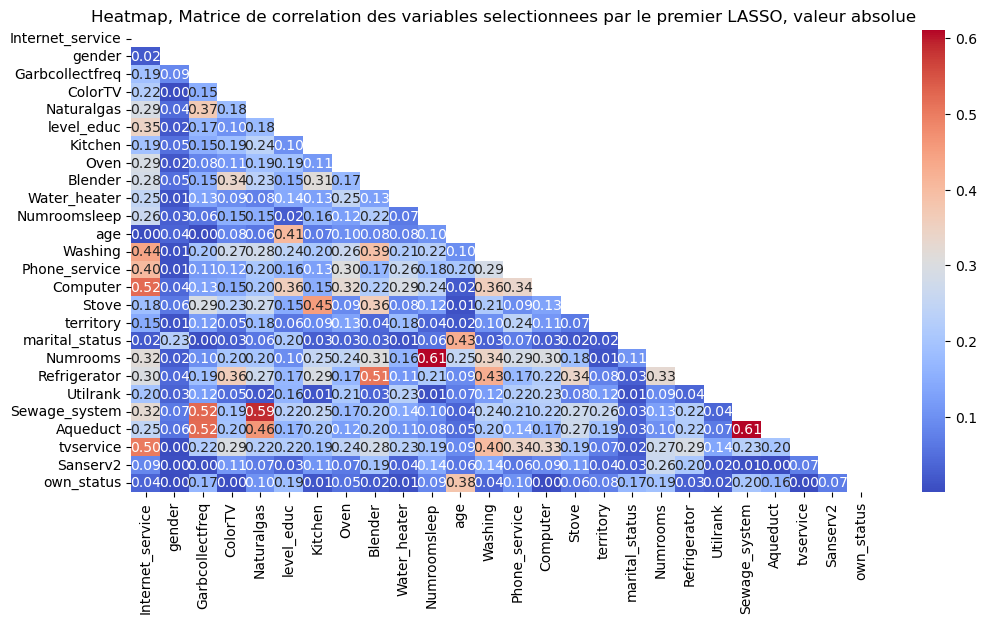

In [86]:
#matrice de correlation

import seaborn as sns
ok = total_dataset_clean[features_after_removal].corr().abs()
mask = np.triu(np.ones_like(ok, dtype=bool))
plt.figure(figsize=(12, 6))
sns.heatmap(ok, mask=mask, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Heatmap, Matrice de correlation des variables selectionnees par le premier LASSO, valeur absolue')
plt.show()

In [87]:
threshold = 0.3
high_correlation_vars = np.where((ok > threshold) & (ok < 1))
high_correlation_pairs = [(features_after_removal[i], features_after_removal[j]) for i, j in zip(*high_correlation_vars)] #les paires qui ont le plus de correlation


In [88]:
print("Paires de correlations")
print(high_correlation_pairs) # complique de selectionner, on relance un lasso

Paires de correlations
[('Internet_service', 'level_educ'), ('Internet_service', 'Washing'), ('Internet_service', 'Phone_service'), ('Internet_service', 'Computer'), ('Internet_service', 'Numrooms'), ('Internet_service', 'Sewage_system'), ('Internet_service', 'tvservice'), ('Garbcollectfreq', 'Naturalgas'), ('Garbcollectfreq', 'Sewage_system'), ('Garbcollectfreq', 'Aqueduct'), ('ColorTV', 'Blender'), ('ColorTV', 'Refrigerator'), ('Naturalgas', 'Garbcollectfreq'), ('Naturalgas', 'Sewage_system'), ('Naturalgas', 'Aqueduct'), ('level_educ', 'Internet_service'), ('level_educ', 'age'), ('level_educ', 'Computer'), ('Kitchen', 'Blender'), ('Kitchen', 'Stove'), ('Oven', 'Phone_service'), ('Oven', 'Computer'), ('Blender', 'ColorTV'), ('Blender', 'Kitchen'), ('Blender', 'Washing'), ('Blender', 'Stove'), ('Blender', 'Numrooms'), ('Blender', 'Refrigerator'), ('Numroomsleep', 'Numrooms'), ('age', 'level_educ'), ('age', 'marital_status'), ('age', 'own_status'), ('Washing', 'Internet_service'), ('Was

In [89]:
# on relance une lasso avec ces variables puis selectionner encore moins de vars

selected_variables_after_removal = vif_data_after_removal["Variable"].tolist()
selected_variables_after_removal = [var for var in selected_variables_after_removal if var != "Numroomsleep"]
selected_variables_after_removal

['Internet_service',
 'gender',
 'Garbcollectfreq',
 'ColorTV',
 'Naturalgas',
 'level_educ',
 'Kitchen',
 'Oven',
 'Blender',
 'Water_heater',
 'age',
 'Washing',
 'Phone_service',
 'Computer',
 'Stove',
 'territory',
 'marital_status',
 'Numrooms',
 'Refrigerator',
 'Utilrank',
 'Sewage_system',
 'Aqueduct',
 'tvservice',
 'Sanserv2',
 'own_status']

In [90]:
#preprocessing
X_bis = total_dataset_clean[vif_data_after_removal["Variable"].tolist()].dropna()
data=X_bis

variables_left = vif_data_after_removal["Variable"].tolist()
if "Numrooms" or "Numroomsleep" or "age" in variables_left:
    variables_left.remove("Numrooms")
    variables_left.remove("Numroomsleep")
    variables_left.remove("age")

variables_left

['Internet_service',
 'gender',
 'Garbcollectfreq',
 'ColorTV',
 'Naturalgas',
 'level_educ',
 'Kitchen',
 'Oven',
 'Blender',
 'Water_heater',
 'Washing',
 'Phone_service',
 'Computer',
 'Stove',
 'territory',
 'marital_status',
 'Refrigerator',
 'Utilrank',
 'Sewage_system',
 'Aqueduct',
 'tvservice',
 'Sanserv2',
 'own_status']

In [91]:
data = data[variables_left]

In [92]:
for column in variables_left:
    dummies = pd.get_dummies(data[column], prefix=column, dtype=float, drop_first=True)
    data = pd.concat([data, dummies], axis=1)
data = data.drop(variables_left, axis=1)

In [93]:
data  

,Internet_service_2.0,gender_2.0,Garbcollectfreq_2.0,Garbcollectfreq_3.0,Garbcollectfreq_4.0,Garbcollectfreq_5.0,Garbcollectfreq_6.0,ColorTV_2.0,Naturalgas_2.0,level_educ_3.0,level_educ_4.0,level_educ_5.0,level_educ_6.0,Kitchen_2.0,Kitchen_3.0,Kitchen_4.0,Kitchen_5.0,Kitchen_6.0,Oven_2.0,Blender_2.0,Water_heater_2.0,Washing_2.0,Phone_service_2.0,Computer_2.0,Stove_2.0,territory_2,territory_3,territory_4,territory_5,territory_6,territory_7,territory_8,territory_9,territory_10,territory_11,marital_status_2.0,marital_status_3.0,marital_status_4.0,marital_status_5.0,Refrigerator_2.0,Utilrank_2.0,Utilrank_3.0,Utilrank_4.0,Utilrank_5.0,Utilrank_6.0,Utilrank_9.0,Sewage_system_2.0,Aqueduct_2.0,tvservice_2.0,Sanserv2_2.0,own_status_1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18133,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
18134,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18135,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
18136,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [94]:

scaler = MinMaxScaler()
data_preprocess = scaler.fit_transform(total_dataset_clean[['Numrooms', 'Numroomsleep']])
data_preprocess = pd.DataFrame(data_preprocess, columns=['Numrooms',"Numroomsleep"])
data_preprocess

,Numrooms,Numroomsleep
0,0.272727,0.000000
1,0.454545,0.500000
2,0.272727,0.166667
3,0.272727,0.166667
4,0.272727,0.333333
...,...,...
18134,0.090909,0.000000
18135,0.090909,0.000000
18136,0.272727,0.166667
18137,0.181818,0.000000


In [95]:
y_bis = total_dataset_clean['log_imputed_rent_uc']
X_bisbis = pd.concat([data, data_preprocess], axis=1)
X_bisbis = pd.concat([X_bisbis, age], axis=1)
X_ybis = pd.concat([X_bisbis,y_bis],axis=1)
X_ybis = X_ybis.dropna()
X_ybis
yb = X_ybis['log_imputed_rent_uc']
Xb = X_ybis.drop(['log_imputed_rent_uc'], axis=1)

Xb

,Internet_service_2.0,gender_2.0,Garbcollectfreq_2.0,Garbcollectfreq_3.0,Garbcollectfreq_4.0,Garbcollectfreq_5.0,Garbcollectfreq_6.0,ColorTV_2.0,Naturalgas_2.0,level_educ_3.0,level_educ_4.0,level_educ_5.0,level_educ_6.0,Kitchen_2.0,Kitchen_3.0,Kitchen_4.0,Kitchen_5.0,Kitchen_6.0,Oven_2.0,Blender_2.0,Water_heater_2.0,Washing_2.0,Phone_service_2.0,Computer_2.0,Stove_2.0,territory_2,territory_3,territory_4,territory_5,territory_6,territory_7,territory_8,territory_9,territory_10,territory_11,marital_status_2.0,marital_status_3.0,marital_status_4.0,marital_status_5.0,Refrigerator_2.0,Utilrank_2.0,Utilrank_3.0,Utilrank_4.0,Utilrank_5.0,Utilrank_6.0,Utilrank_9.0,Sewage_system_2.0,Aqueduct_2.0,tvservice_2.0,Sanserv2_2.0,own_status_1,Numrooms,Numroomsleep,age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.000000,58.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.500000,42.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.166667,44.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.166667,49.0
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.272727,0.333333,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18133,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.181818,0.166667,38.0
18134,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.090909,0.000000,56.0
18135,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.090909,0.000000,40.0
18136,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.272727,0.166667,60.0


In [96]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xb, yb, test_size=0.2, random_state=42)


In [97]:
#cross validation pour determiner le alpha optimal 

from sklearn.linear_model import LassoCV

# LassoCV model avec cross-validation
lasso_model2 = LassoCV(alphas=np.logspace(-25, 0, 200), cv=5, max_iter=100)

# on fitte les donnees avec les data_train2
lasso_model2.fit(X_train2, y_train2)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.585020921843352, tolerance: 0.5425417926850249
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.234934703289127, tolerance: 0.5425417926850249
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.712073906589239, tolerance: 0.5425417926850249
  model = cd_fast.enet_coordinate_descent_gram(
/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: Convergenc

LassoCV(alphas=array([1.00000000e-25, 1.33545156e-25, 1.78343088e-25, 2.38168555e-25,
       3.18062569e-25, 4.24757155e-25, 5.67242607e-25, 7.57525026e-25,
       1.01163798e-24, 1.35099352e-24, 1.80418641e-24, 2.40940356e-24,
       3.21764175e-24, 4.29700470e-24, 5.73844165e-24, 7.66341087e-24,
       1.02341140e-23, 1.36671636e-23, 1.82518349e-23, 2.43744415e-23,
       3.25508860e-23, 4.34701316e-2...
       1.28989026e-03, 1.72258597e-03, 2.30043012e-03, 3.07211300e-03,
       4.10265811e-03, 5.47890118e-03, 7.31680714e-03, 9.77124154e-03,
       1.30490198e-02, 1.74263339e-02, 2.32720248e-02, 3.10786619e-02,
       4.15040476e-02, 5.54266452e-02, 7.40196000e-02, 9.88495905e-02,
       1.32008840e-01, 1.76291412e-01, 2.35428641e-01, 3.14403547e-01,
       4.19870708e-01, 5.60716994e-01, 7.48810386e-01, 1.00000000e+00]),
        cv=5, max_iter=100)

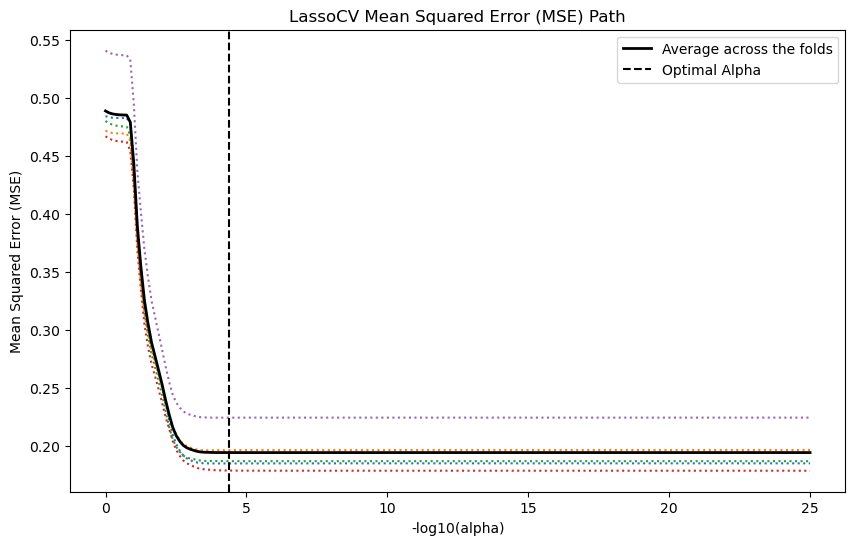

In [98]:
# plot alpha optimal 
m_log_alphas = -np.log10(lasso_model2.alphas_)

plt.figure(figsize=(10, 6))
plt.plot(m_log_alphas, lasso_model2.mse_path_, ':')
plt.plot(m_log_alphas, lasso_model2.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso_model2.alpha_), linestyle='--', color='k', label='Optimal Alpha')

plt.legend()
plt.xlabel('-log10(alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LassoCV Mean Squared Error (MSE) Path')
plt.show() 

In [99]:
test_score = lasso_model2.score(X_test2, y_test2)
print(f'R-squared: {test_score}')
# meilleur qu'avant : on a supprime les variables multicollineaires

R-squared: 0.6531548795244617


In [100]:
optimal_alpha2 = lasso_model2.alpha_
optimal_alpha_original_scale2 = 10**optimal_alpha2
print(f'Alpha optimal: {optimal_alpha_original_scale2}')

Alpha optimal: 1.0000923104372825


In [101]:
lasso_model2_selec = Lasso(alpha=optimal_alpha2)  # utilise le alpha optimal
lasso_model2_selec.fit(X_train2, y_train2)

#on applique aux datas test et on calcule le MSE
y_pred2 = lasso_model2_selec.predict(X_test2)
mse = mean_squared_error(y_test2, y_pred2)

print(f'Mean Squared Error: {mse}')
print("Ce nested LASSO permet aussi de reduire le MSE \nOn garde ces variables et on teste le VIF avec la regression")

Mean Squared Error: 0.16381601313672642
Ce nested LASSO permet aussi de reduire le MSE 
On garde ces variables et on teste le VIF avec la regression


In [102]:
to_exclude = coefficients_df[coefficients_df['Coefficient'].abs()==0]
to_exclude.T
to_exclude = [element.split('_')[0] for element in to_exclude['Variable']]
to_exclude = list(set(to_exclude))
to_exclude

['Watserv',
 'Garbdisp',
 'Floor',
 'Stereo',
 'Fuelc',
 'Frequencewat',
 'Wallsmaterial',
 'Sanserv1']

In [103]:
coefficients_df2 = pd.DataFrame({'Variable': Xb.columns, 'Coefficient': lasso_model2_selec.coef_})
coefficients_df2
tokeep = [element.split('_')[0] for element in coefficients_df2['Variable']]
tokeep = list(set(tokeep))
tokeep

['Internet',
 'gender',
 'Garbcollectfreq',
 'ColorTV',
 'Naturalgas',
 'level',
 'Kitchen',
 'Oven',
 'Blender',
 'Water',
 'Numroomsleep',
 'age',
 'Washing',
 'Phone',
 'Computer',
 'Stove',
 'territory',
 'marital',
 'Numrooms',
 'Refrigerator',
 'Utilrank',
 'Sewage',
 'Aqueduct',
 'tvservice',
 'Sanserv2',
 'own']

In [ ]:
# cette fois ci aussi, nos variables sociocategorielles ont ete sauvegardees 
# on regarde a nouveau pour la multicollinearite

In [104]:
#renommer 
tokeep = [replacement_dict.get(col, col) for col in tokeep]

print(f'Les covariables retenues :{tokeep}')

Les covariables retenues :['Internet_service', 'gender', 'Garbcollectfreq', 'ColorTV', 'Naturalgas', 'level_educ', 'Kitchen', 'Oven', 'Blender', 'Water_heater', 'Numroomsleep', 'age', 'Washing', 'Phone_service', 'Computer', 'Stove', 'territory', 'marital_status', 'Numrooms', 'Refrigerator', 'Utilrank', 'Sewage_system', 'Aqueduct', 'tvservice', 'Sanserv2', 'own_status']


In [ ]:
################ VIF et tables de correlations : pas la peine de continuer, voir directement dans 4_reg_finale

#traiteNaN
data_after_removal_bis = total_dataset_clean[tokeep].copy()
data_after_removal_bis.dropna(inplace=True)

vif_data_after_removal_bis = pd.DataFrame()
vif_data_after_removal_bis["Variable"] = data_after_removal_bis.columns
vif_data_after_removal_bis["VIF"] = [variance_inflation_factor(data_after_removal_bis.values, i) for i in range(data_after_removal_bis.shape[1])]
vif_data_after_removal_bis

In [106]:
#matrice de correlation #### muted

import seaborn as sns
ok = total_dataset_clean[tokeep].corr().abs()
mask = np.triu(np.ones_like(ok, dtype=bool))
#plt.figure(figsize=(12, 6))
#sns.heatmap(ok, mask=mask, annot=True, cmap="coolwarm", fmt='.2f')
#plt.title('Heatmap, Matrice de correlation des variables selectionnees, valeur absolue')
#plt.show()